In [1]:
import random
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import Levenshtein
import networkx as nx

from collections import defaultdict
from itertools import product, combinations

In [2]:
DATASET_DIRECTORY = '../datasets/new'

In [3]:
def report_pairing(df):
    print('Number of paired sequences: {:15}'.format(len(df)))
    print('Number of unique heavy:     {:15}'.format(df['heavy_id'].nunique()))
    print('Number of unique light:     {:15}'.format(df['light_id'].nunique()))
    print('Number of unique pairs:     {:15} ({:.2f}%)'.format(df['pair_id'].nunique(),
                                                            df['pair_id'].nunique() / len(df) * 100))
def report_germlines(df):
    print('Number of heavy germlines:  {:15}'.format(df['heavy_germline'].nunique()))
    print('Number of light germlines:  {:15}'.format(df['light_germline'].nunique()))
    print('Number of germlines pair:   {:15}'.format(len(df[['heavy_germline', 'light_germline']].drop_duplicates())))
    print('Number of V heavy germlines:{:15}'.format(len(df['heavy_germline'].map(lambda x: x.split('-')[0]).drop_duplicates())))
    print('Number of D heavy germlines:{:15}'.format(len(df['heavy_germline'].map(lambda x: x.split('-')[1]).drop_duplicates())))
    print('Number of J heavy germlines:{:15}'.format(len(df['heavy_germline'].map(lambda x: x.split('-')[2]).drop_duplicates())))
    print('Number of V light germlines:{:15}'.format(len(df['light_germline'].map(lambda x: x.split('-')[0]).drop_duplicates())))
    print('Number of J light germlines:{:15}'.format(len(df['light_germline'].map(lambda x: x.split('-')[1]).drop_duplicates())))

def show_germline_counter(heavy_germlines, light_germlines, ax_heavy, ax_light):
    ax_heavy.bar(range(len(heavy_germlines)), heavy_germlines.map(np.log10))
    ax_light.bar(range(len(light_germlines)), light_germlines.map(np.log10))

def show_coocc_matrix(coocc_matrix, heavy_germlines, light_germlines, ax):
    ret = ax.imshow(np.log10(coocc_matrix + 1))
    ax.set_xticks([])
    ax.set_yticks([])
    return ret

### All sequences 

In [4]:
all_sequences = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'sequences/sequences.csv'), index_col=0)
report_pairing(all_sequences)
print()
report_germlines(all_sequences)

Number of paired sequences:         1622802
Number of unique heavy:             1604717
Number of unique light:              699889
Number of unique pairs:             1622674 (99.99%)

Number of heavy germlines:              294
Number of light germlines:               76
Number of germlines pair:             12416
Number of V heavy germlines:              7
Number of D heavy germlines:              7
Number of J heavy germlines:              6
Number of V light germlines:             18
Number of J light germlines:             12


### Clusters 

In [5]:
clusters = pd.read_csv('{}/clustering/sequences.tsv'.format(DATASET_DIRECTORY), sep='\t', header=None).rename({
    0: 'representative',
    1: 'sequences'
    
}, axis=1)

In [6]:
sizes = []
for _, data in clusters.groupby('representative'):
    sizes.append(len(data))

In [7]:
print('Number of clusters: {}'.format(clusters['representative'].nunique()))
print('Mean size:   {:.3f}\nMedian size: {:.0f}'.format(np.mean(sizes), np.median(sizes)))
sizes_dict = defaultdict(int)
for s in sizes:
    sizes_dict[s] += 1
sizes_df = defaultdict(list)
for key, item in sizes_dict.items():
    sizes_df['size'].append(key)
    sizes_df['number'].append(item)
sizes_df = pd.DataFrame(sizes_df)
sizes_df = sizes_df.sort_values(by='size')
print('Number of singleton: {}'.format(sizes_df.iloc[0, 1]))
print('Lergest cluster: {}'.format(sizes_df.iloc[-1, 0]))

Number of clusters: 1357063
Mean size:   1.196
Median size: 1
Number of singleton: 1290392
Lergest cluster: 3940


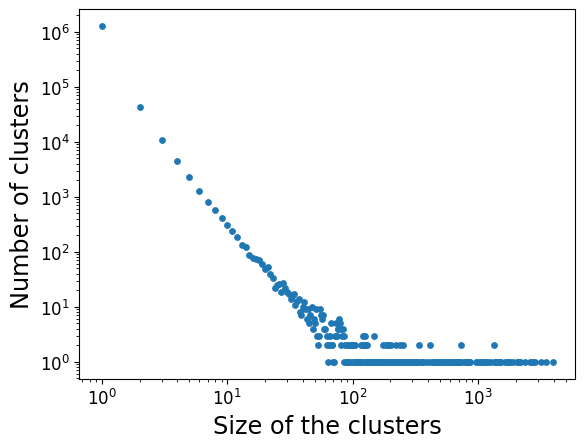

In [8]:
fig, ax = plt.subplots(1)

ax.scatter(sizes_df['size'], sizes_df['number'], s=15)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel('Number of clusters', fontsize='xx-large')
ax.set_xlabel('Size of the clusters', fontsize='xx-large')

ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig('pictures/cluster-scatterplot.png', bbox_inches='tight')

### Clusters only representative

In [9]:
representative_sequences = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'sequences/representative.csv'), index_col=0)
report_pairing(representative_sequences)
print()
report_germlines(representative_sequences)

Number of paired sequences:         1357155
Number of unique heavy:             1348625
Number of unique light:              595539
Number of unique pairs:             1357063 (99.99%)

Number of heavy germlines:              294
Number of light germlines:               76
Number of germlines pair:             11976
Number of V heavy germlines:              7
Number of D heavy germlines:              7
Number of J heavy germlines:              6
Number of V light germlines:             18
Number of J light germlines:             12


### Germline based splitting

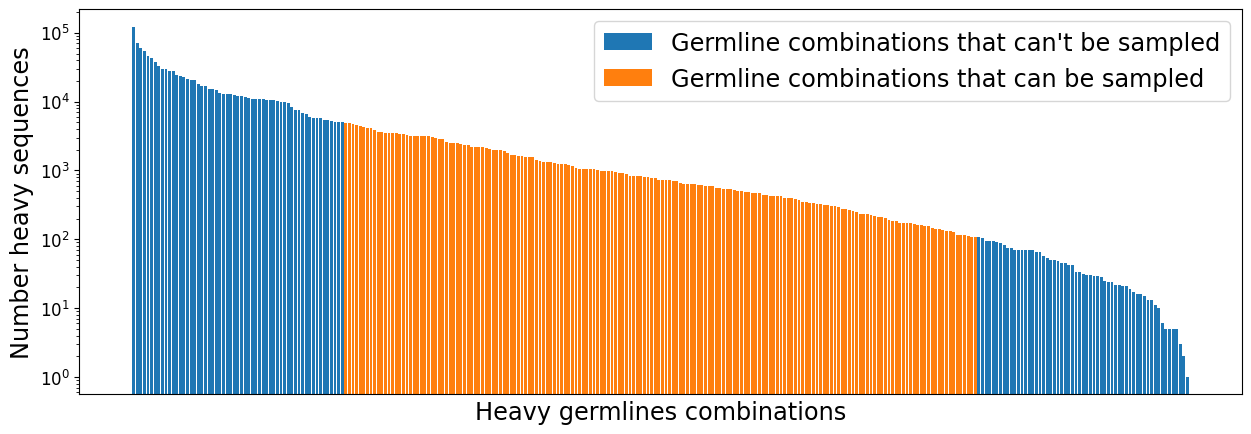

In [10]:
counter = representative_sequences.groupby('heavy_germline').count()['heavy_id'].sort_values(ascending=False)
selected = counter[(counter > counter.quantile(0.20)) & (counter < counter.quantile(0.80))]

fig, ax = plt.subplots(1)

ax.bar(range(len(counter)), counter)

a = counter.index.get_loc(selected.index[0])
b = counter.index.get_loc(selected.index[-1])
ax.bar(range(a, b + 1), selected)

ax.set_yscale('log')

ax.legend(['Germline combinations that can\'t be sampled', 'Germline combinations that can be sampled'],
          fontsize="xx-large")

ax.set_xticks([])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel('Number heavy sequences', fontsize='xx-large')
ax.set_xlabel('Heavy germlines combinations', fontsize='xx-large')

fig.set_size_inches(15, 5)
fig.savefig('pictures/heavy-germlines-combinations-count.png', bbox_inches='tight')

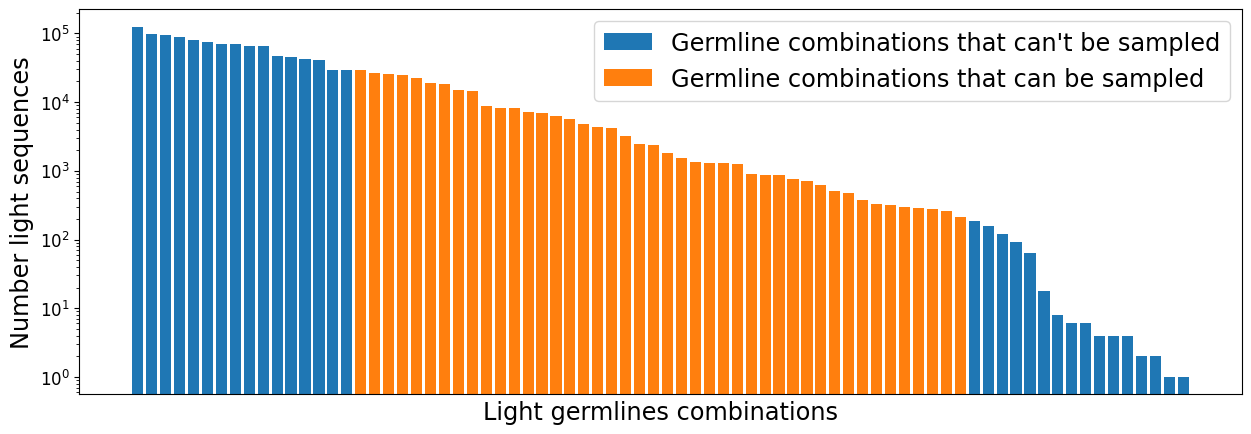

In [11]:
counter = representative_sequences.groupby('light_germline').count()['light_id'].sort_values(ascending=False)
selected = counter[(counter > counter.quantile(0.20)) & (counter < counter.quantile(0.80))]

fig, ax = plt.subplots(1)

ax.bar(range(len(counter)), counter)

a = counter.index.get_loc(selected.index[0])
b = counter.index.get_loc(selected.index[-1])
ax.bar(range(a, b + 1), selected)

ax.set_yscale('log')

ax.legend(['Germline combinations that can\'t be sampled', 'Germline combinations that can be sampled'],
          fontsize='xx-large')

ax.set_xticks([])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel('Number light sequences', fontsize='xx-large')
ax.set_xlabel('Light germlines combinations', fontsize='xx-large')

fig.set_size_inches(15, 5)
fig.savefig('pictures/light-germlines-combinations-count.png', bbox_inches='tight')

### Train sequences

In [12]:
train_sequences = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'sequences/train.csv'), index_col=0)
report_pairing(train_sequences)
print()
report_germlines(train_sequences)

Number of paired sequences:          716325
Number of unique heavy:              713129
Number of unique light:              325309
Number of unique pairs:              716295 (100.00%)

Number of heavy germlines:              261
Number of light germlines:               68
Number of germlines pair:              8628
Number of V heavy germlines:              7
Number of D heavy germlines:              7
Number of J heavy germlines:              6
Number of V light germlines:             18
Number of J light germlines:             12


### Val sequences

In [13]:
val_sequences = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'sequences/val.csv'), index_col=0)
report_pairing(val_sequences)
print()
report_germlines(val_sequences)

Number of paired sequences:          271233
Number of unique heavy:              270406
Number of unique light:              134013
Number of unique pairs:              271230 (100.00%)

Number of heavy germlines:              270
Number of light germlines:               68
Number of germlines pair:              8125
Number of V heavy germlines:              7
Number of D heavy germlines:              7
Number of J heavy germlines:              6
Number of V light germlines:             17
Number of J light germlines:             11


### Test sequences

In [14]:
test_sequences = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'sequences/test.csv'), index_col=0)
report_pairing(test_sequences)
print()
report_germlines(test_sequences)

Number of paired sequences:          369597
Number of unique heavy:              368303
Number of unique light:              176290
Number of unique pairs:              369586 (100.00%)

Number of heavy germlines:              291
Number of light germlines:               73
Number of germlines pair:              9575
Number of V heavy germlines:              7
Number of D heavy germlines:              7
Number of J heavy germlines:              6
Number of V light germlines:             17
Number of J light germlines:             11


### Random pairing

In [15]:
WHICH = 'train'

random_pairs = pd.read_csv('{}/classificator/random/{}_random/{}_random.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/random/{}_random/{}.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          716325
Number of unique heavy:              451185
Number of unique light:              212387
Number of unique pairs:              716097 (99.97%)
1432650 716325 716325


In [16]:
WHICH = 'val'

random_pairs = pd.read_csv('{}/classificator/random/{}_random/{}_random.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/random/{}_random/{}.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          271233
Number of unique heavy:              171061
Number of unique light:               87773
Number of unique pairs:              271142 (99.97%)
542466 271233 271233


In [17]:
WHICH = 'test'

random_pairs = pd.read_csv('{}/classificator/random/{}_random/{}_random.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/random/{}_random/{}.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          369597
Number of unique heavy:              232860
Number of unique light:              115172
Number of unique pairs:              369481 (99.97%)
739194 369597 369597


### Germline pairing - ALL

In [4]:
germline_file_all = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/germline_all/train/train_germ.csv'), index_col=0)
heavy_germlines = germline_file_all.groupby('heavy_germline')['counter'].sum().sort_values(ascending=False)
light_germlines = germline_file_all.groupby('light_germline')['counter'].sum().sort_values(ascending=False)

coocc_matrix_train = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        coocc_matrix_train[r][c] = germline_file_all[(germline_file_all['heavy_germline'] == h) & 
                                                     (germline_file_all['light_germline'] == l)]['counter'].iloc[0]

In [5]:
train_neg = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                       'classificator/germline_all/train/train-germline_pairing-alpha_1000.csv'), index_col=0)
germlines_train = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                             'classificator/germline_all/train/train_germ.csv'), index_col=0)

train_neg = pd.merge(train_neg, germlines_train, how='left')

zero_pairs = defaultdict(list)

for h, data1 in train_neg.groupby('heavy_germline'):
    for l, data2 in data1.groupby('light_germline'):
        zero_pairs['heavy_germline'].append(h)
        zero_pairs['light_germline'].append(l)
        zero_pairs['count'].append(len(data2))

zero_pairs = pd.DataFrame(zero_pairs)

coocc_matrix_train_zero = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        x = zero_pairs[(zero_pairs['heavy_germline'] == h) &
                       (zero_pairs['light_germline'] == l)]['count']
        if len(x) != 0:
            coocc_matrix_train_zero[r][c] = x.iloc[0]

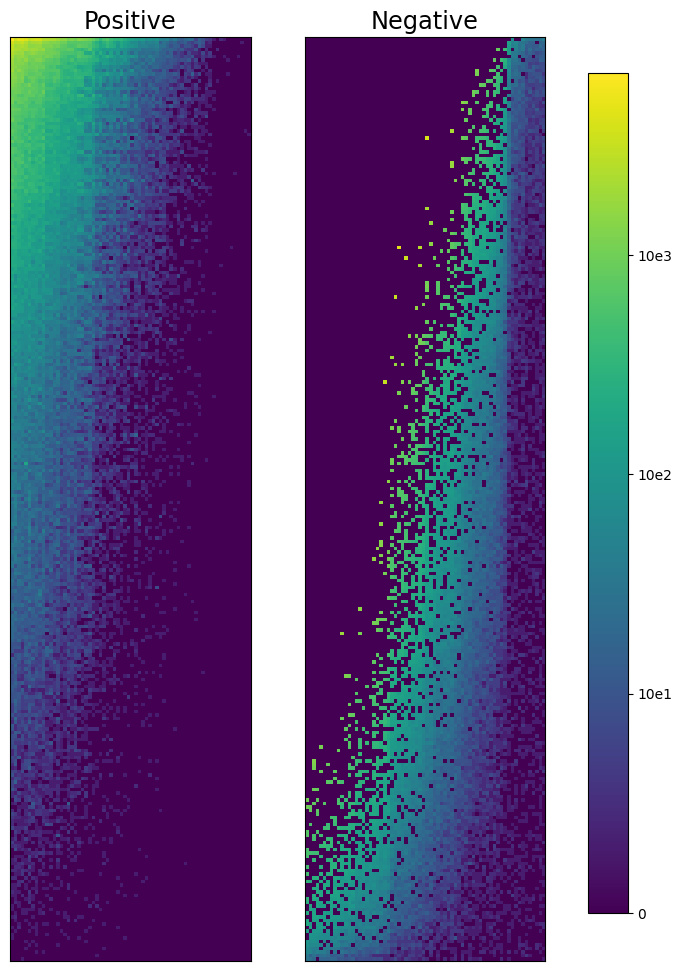

In [14]:
vmin = 0
vmax = max(np.max(coocc_matrix_train_zero), np.max(coocc_matrix_train))

fig, axs = plt.subplots(1, 2)
axs = axs.flatten()

fig.set_size_inches(8, 12)

ret1 = axs[0].imshow(np.log10(coocc_matrix_train + 1), vmin=0, vmax=np.log10(vmax))
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Positive', fontsize='xx-large')

axs[1].imshow(np.log10(coocc_matrix_train_zero + 1), vmin=0, vmax=np.log10(vmax))
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Negative', fontsize='xx-large')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ret1, cbar_ax, axs)

cbar_ax.set_yticks([0, 1, 2, 3])
cbar_ax.set_yticklabels(['0', '10e1', '10e2', '10e3'])

fig.savefig('pictures/co-occ-matrix-train-germ-all.png', bbox_inches='tight')

In [15]:
WHICH = 'train'

random_pairs = pd.read_csv('{}/classificator/germline_all/{}/{}-germline_pairing-alpha_1000.csv'.format(DATASET_DIRECTORY, 
                                                                                                        WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/germline_all/{}/{}.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          716325
Number of unique heavy:              172284
Number of unique light:              102598
Number of unique pairs:              702818 (98.11%)
1432650 716325 716325


In [16]:
WHICH = 'val'

random_pairs = pd.read_csv('{}/classificator/germline_all/{}/{}-germline_pairing-alpha_1000.csv'.format(DATASET_DIRECTORY, 
                                                                                                        WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/germline_all/{}/{}.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          271233
Number of unique heavy:               79278
Number of unique light:               50571
Number of unique pairs:              268702 (99.07%)
542466 271233 271233


In [17]:
WHICH = 'test'

random_pairs = pd.read_csv('{}/classificator/germline_all/{}/{}-germline_pairing-alpha_1000.csv'.format(DATASET_DIRECTORY, 
                                                                                                        WHICH, WHICH), index_col=0)
report_pairing(random_pairs)

random_pairs_total = pd.read_csv('{}/classificator/germline_all/{}/{}.csv'.format(DATASET_DIRECTORY, WHICH, WHICH), index_col=0)
print(len(random_pairs_total), 
      len(random_pairs_total[random_pairs_total['class'] == 0]),
      len(random_pairs_total[random_pairs_total['class'] == 1]))

Number of paired sequences:          369597
Number of unique heavy:              109264
Number of unique light:               62194
Number of unique pairs:              366160 (99.07%)
739194 369597 369597


In [27]:
germline_file_all = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/germline_all/val/val_germ.csv'), index_col=0)
heavy_germlines = germline_file_all.groupby('heavy_germline')['counter'].sum().sort_values(ascending=False)
light_germlines = germline_file_all.groupby('light_germline')['counter'].sum().sort_values(ascending=False)

coocc_matrix_val = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        coocc_matrix_val[r][c] = germline_file_all[(germline_file_all['heavy_germline'] == h) & 
                                                   (germline_file_all['light_germline'] == l)]['counter'].iloc[0]

In [28]:
germline_file_all = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/germline_all/val/val_germ.csv'), index_col=0)
heavy_germlines = germline_file_all.groupby('heavy_germline')['counter'].sum().sort_values(ascending=False)
light_germlines = germline_file_all.groupby('light_germline')['counter'].sum().sort_values(ascending=False)

coocc_matrix_test = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        coocc_matrix_test[r][c] = germline_file_all[(germline_file_all['heavy_germline'] == h) & 
                                                   (germline_file_all['light_germline'] == l)]['counter'].iloc[0]

In [22]:
coocc_matrix = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        coocc_matrix[r][c] = germline_file_all[(germline_file_all['heavy_germline'] == h) & 
                                               (germline_file_all['light_germline'] == l)]['counter'].iloc[0]

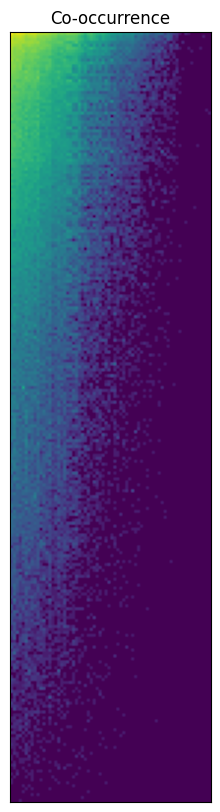

In [23]:
fig, ax = plt.subplots(1)

fig.set_size_inches(3, 10)

show_coocc_matrix(coocc_matrix, heavy_germlines, light_germlines, ax=ax)

In [47]:
train_neg = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                       'classificator/train/train-germline_pairing-alpha_1000.csv'), index_col=0)
germlines_train = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                             'classificator/train/train_germ.csv'), index_col=0)

train_neg = pd.merge(train_neg, germlines_train, how='left')

In [48]:
zero_pairs = defaultdict(list)

for h, data1 in train_neg.groupby('heavy_germline'):
    for l, data2 in data1.groupby('light_germline'):
        zero_pairs['heavy_germline'].append(h)
        zero_pairs['light_germline'].append(l)
        zero_pairs['count'].append(len(data2))

zero_pairs = pd.DataFrame(zero_pairs)

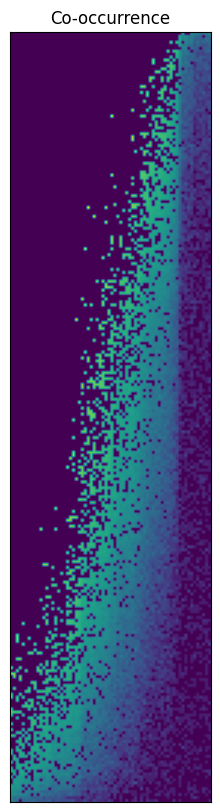

In [49]:
coocc_matrix_zero = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        x = zero_pairs[(zero_pairs['heavy_germline'] == h) &
                       (zero_pairs['light_germline'] == l)]['count']
        if len(x) != 0:
            coocc_matrix_zero[r][c] = x.iloc[0]

fig, ax = plt.subplots(1)

fig.set_size_inches(3, 10)

show_coocc_matrix(coocc_matrix_zero, heavy_germlines, light_germlines, ax)

### Germline pairing - only v

In [53]:
germline_file_all = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/train_only_v/train_germ_only_v.csv'), index_col=0)
heavy_germlines = germline_file_all.groupby('heavy_germline')['counter'].sum().sort_values(ascending=False)
light_germlines = germline_file_all.groupby('light_germline')['counter'].sum().sort_values(ascending=False)

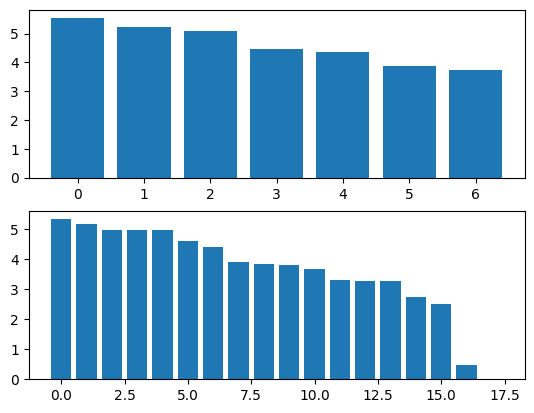

In [54]:
fig, axs = plt.subplots(2, 1)
axs = axs.flatten()

show_germline_counter(heavy_germlines, light_germlines, ax_heavy=axs[0], ax_light=axs[1])

In [55]:
coocc_matrix = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        coocc_matrix[r][c] = germline_file_all[(germline_file_all['heavy_germline'] == h) & 
                                               (germline_file_all['light_germline'] == l)]['counter'].iloc[0]

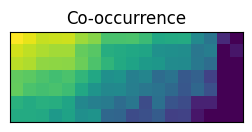

In [56]:
fig, ax = plt.subplots(1)

fig.set_size_inches(3, 10)

show_coocc_matrix(coocc_matrix, heavy_germlines, light_germlines, ax=ax)

In [58]:
train_neg = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                       'classificator/train_only_v/train-germline_pairing-alpha_1000_only_v.csv'), index_col=0)
germlines_train = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 
                                             'classificator/train_only_v/train_germ_only_v.csv'), index_col=0)

train_neg = pd.merge(train_neg, germlines_train, how='left')

In [59]:
zero_pairs = defaultdict(list)

for h, data1 in train_neg.groupby('heavy_germline'):
    for l, data2 in data1.groupby('light_germline'):
        zero_pairs['heavy_germline'].append(h)
        zero_pairs['light_germline'].append(l)
        zero_pairs['count'].append(len(data2))

zero_pairs = pd.DataFrame(zero_pairs)

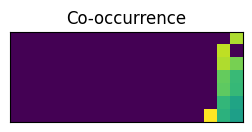

In [60]:
coocc_matrix_zero = np.zeros([len(heavy_germlines), len(light_germlines)])

for r, h in enumerate(heavy_germlines.index):
    for c, l in enumerate(light_germlines.index):
        x = zero_pairs[(zero_pairs['heavy_germline'] == h) &
                       (zero_pairs['light_germline'] == l)]['count']
        if len(x) != 0:
            coocc_matrix_zero[r][c] = x.iloc[0]

fig, ax = plt.subplots(1)

fig.set_size_inches(3, 10)

show_coocc_matrix(coocc_matrix_zero, heavy_germlines, light_germlines, ax)

### Similarity

In [60]:
paired_df = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/train/train_seq.csv'), index_col=0)
random_df = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/train_random/train_random.csv'), index_col=0)
germline_all_df = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/train/train-germline_pairing-alpha_1000.csv'),
                           index_col=0)
germline_v_df = pd.read_csv('{}/{}'.format(DATASET_DIRECTORY, 'classificator/train_only_v/train-germline_pairing-alpha_1000_only_v.csv'),
                         index_col=0)

In [61]:
heavy_ids = set(paired_df['heavy_id'])
heavy_ids = heavy_ids.intersection(set(random_df['heavy_id']))
heavy_ids = heavy_ids.intersection(set(germline_all_df['heavy_id']))
heavy_ids = heavy_ids.intersection(set(germline_v_df['heavy_id']))

In [62]:
sampled_heavy = random.sample(list(heavy_ids), 1000)

In [63]:
paired_seq = []
for s in sampled_heavy:
    x = paired_df[paired_df['heavy_id'] == s][['heavy', 'light']].iloc[0, :]
    paired_seq.append('{}{}'.format(x['heavy'], x['light']))

In [64]:
random_seq = []
for s in sampled_heavy:
    x = random_df[random_df['heavy_id'] == s][['heavy', 'light']].iloc[0, :]
    random_seq.append('{}{}'.format(x['heavy'], x['light']))

In [65]:
germline_v_seq = []
for s in sampled_heavy:
    x = germline_v_df[germline_v_df['heavy_id'] == s][['heavy', 'light']].iloc[0, :]
    germline_v_seq.append('{}{}'.format(x['heavy'], x['light']))

In [66]:
germline_all_seq = []
for s in sampled_heavy:
    x = germline_all_df[germline_all_df['heavy_id'] == s][['heavy', 'light']].iloc[0, :]
    germline_all_seq.append('{}{}'.format(x['heavy'], x['light']))

In [74]:
def intra_sim(l):
    values = []
    for x, y in combinations(l, 2):
        values.append(Levenshtein.ratio(x, y))
    print('|{:^10}|{:^10}|{:^10}|{:^10}|'.format('mean', 'std', 'min', 'max'))
    print('|{:^10.4f}|{:^10.4f}|{:^10.4f}|{:^10.4f}|'.format(
        np.mean(values), np.std(values), np.min(values), np.max(values)))

print('Intra-distance')
print()
print('paired')
intra_sim(paired_seq)
print()
print('random')
intra_sim(random_seq)
print()
print('germline_v')
intra_sim(germline_v_seq)
print()
print('germline_all')
intra_sim(germline_all_seq)

Intra-distance

paired
|   mean   |   std    |   min    |   max    |
|  0.6242  |  0.0843  |  0.4163  |  0.9784  |

random
|   mean   |   std    |   min    |   max    |
|  0.6226  |  0.0834  |  0.4301  |  0.9698  |

germline_v
|   mean   |   std    |   min    |   max    |
|  0.6697  |  0.1249  |  0.3958  |  0.9899  |

germline_all
|   mean   |   std    |   min    |   max    |
|  0.5876  |  0.0882  |  0.3974  |  0.9873  |


In [75]:
def inter_sim(l1, l2):
    values = []
    for x, y in product(l1, l2):
        values.append(Levenshtein.ratio(x, y))
    print('|{:^10}|{:^10}|{:^10}|{:^10}|'.format('mean', 'std', 'min', 'max'))
    print('|{:^10.4f}|{:^10.4f}|{:^10.4f}|{:^10.4f}|'.format(
        np.mean(values), np.std(values), np.min(values), np.max(values)))

print('Inter-distance')
print()
print('random')
inter_sim(paired_seq, random_seq)
print()
print('germline_v')
inter_sim(paired_seq, germline_v_seq)
print()
print('germline_all')
inter_sim(paired_seq, germline_all_seq)

Inter-distance

random
|   mean   |   std    |   min    |   max    |
|  0.6235  |  0.0840  |  0.4077  |  0.9957  |

germline_v
|   mean   |   std    |   min    |   max    |
|  0.5279  |  0.0608  |  0.3859  |  0.8283  |

germline_all
|   mean   |   std    |   min    |   max    |
|  0.5875  |  0.0698  |  0.4142  |  0.9871  |
